**Содержание**:

1. Теория
2. [Практический ноутбук](https://colab.research.google.com/drive/1Q78SIkgM8HyGXYtnYx_aOg574VQrMzWG?usp=sharing)

## <center> Задача image2image с помощью «ГАН'ов» с условием</center>
<center><text size=14>Conditional Generate Adversarial Networks</size></center>

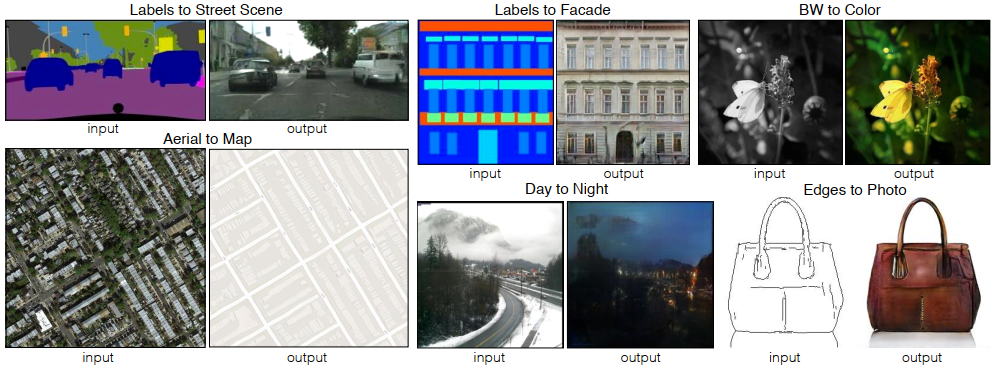
Рис.1

Многие проблемы обработки изображений, графики и компьютерного зрения связаны с преобразованием входного изображения в соответствующее выходное изображение. Эти проблемы часто решаются с помощью алгоритмов для конкретных задач, даже если цель всегда одна и та же: сопоставить пиксели с пикселями. **Состязательные сети с условием — это универсальное решение**, которое хорошо работает с широким спектром таких проблем. На рисунке выше показаны результаты метода на нескольких задачах. В каждом случае используется одна и та же архитектура, а модель просто тренируется на разных данных.

**Conditional GAN** уже давно известен и использовался в ряде работ, таких как прогнозирование будущего кадра, создание сгегнерированных фотографий, создание изображений из простых описаний и т.д. Но в каждой из упомянутых работы метод был адаптирован для решеня конретной задачи. Метод авторов **pix2pix** отличается тем, что он не зависит от конкретной задачи. Это значительно его упрощает, по сравнению с большинством других. Pix2Pix был представлен Филипом Изола и др. в своей статье 2016 года под названием «Преобразование изображения в изображение с помощью состязательных сетей с условием», представленной на CVPR в 2017 году. 

Архитектура GAN состоит из модели **генератора** (для вывода новых правдоподобных сгенерированных изображений) и модели **дискриминатора**, которая классифицирует изображения на реальные (из обучающего набора данных) и поддельные (сгенерированные). 

Модель дискриминатора обновляется напрямую, тогда как модель генератора обновляется через модель дискриминатора. Таким образом, две модели обучаются одновременно в состязательном процессе, в котором генератор пытается лучше обмануть дискриминатор, а дискриминатор пытается лучше идентифицировать поддельные изображения.

Модель Pix2Pix - это тип GAN с условием, или cGAN, где создание выходного изображения зависит от входа, в данном случае исходного изображения. Дискриминатору предоставляется как исходное изображение, так и целевое изображение, и он должен определять, является ли цель правдоподобным преобразованием исходного изображения.

Генератор обучается исользуя состязательную ошибку (Adversarial loss - L2), что побуждает генератор генерировать правдоподобные изображения в целевом наборе данных. Генератор также обновляется с помощью ошибки L1 (MAE), рассчитываемой между сгенерированным изображением и ожидаемым выходным изображением. Эта дополнительная потеря побуждает модель генератора создавать правдоподобные трансформации исходного изображения.

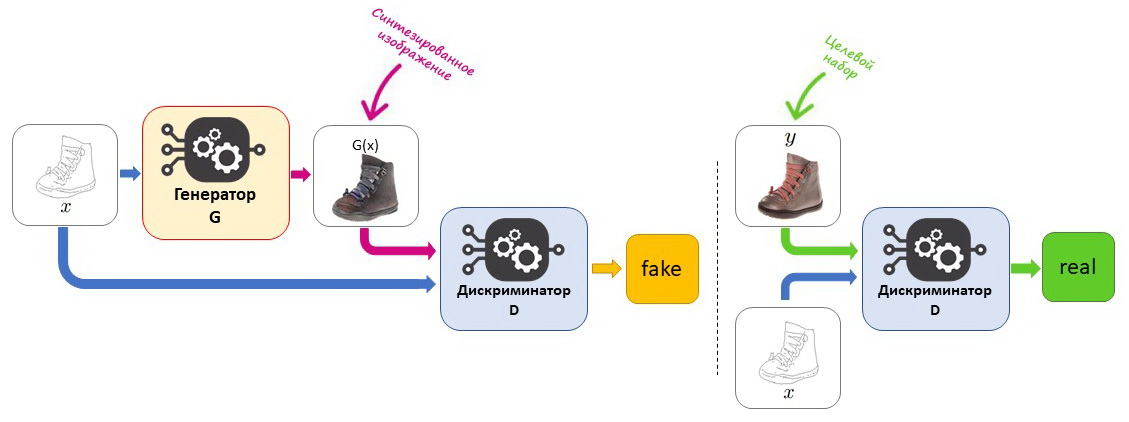<b>Рис.2</b>

Теперь мы, в кратце знакомы с архитектурой Pix2Pix, давайте же посмотрим, как реализовать ее при помощи библиотеки Keras

## Дискриминатор (PatchGAN)

### Ключь к пониманию PatchGAN - рецептивное поле <br>
В архитектуре Pix2Pix модель дискриминатора реализована в виде PatchGAN.
**Основой PatchGAN является размера рецептивного поля**, иногда называемого эффективным рецептивным полем (поле восприятия). Эффективное поле восприятия - это отношение между выходом модели и количеством пикселей входного изображения (фактическое значение оценки, по мере продвижения по входным каналам).<br>PatchGAN спрокетирован таким образом, что каждый "пиксель" выходного "изображения" соответствует квадрату (фрагменту) 70х70 входного изображения. Т.е. как бы используя размер входного окна 70х70, проходит им по входному изображению, классифицируя каждый его фрагмент (отсюда название - Patch), как настоящее или поддельное.

По факту мы проходим каскадом сверточных слоев Conv2D, с ядром свертки 4х4 по входному изображению и получаем на выходе квадратную карту активаций 16х16. Значение в каждой точке которой представляет собой вероятность того, что фрагмент во входном изображении является реальным. Далее эти значения могут быть усреднены для получения общей вероятности или классификационной оценки, при необходимости.

Поле восприятия - не имеет отношение к размеру выхода Дискриминатора. Традиционно поле восприятия относится к размеру карты активации одного сверточного слоя по отношению к входному слою, количеству фильтров и размеру шага. Эффективное поле восприятия обобщает эту идею и вычисляет поле восприятия для выхода всех сверточных слоев с учетом входного, необработанного изображения. Эти термины часто используют, как синонимы


> Преимущество такого подхода заключается в том, что одна и таже модель может применяться к входным изображениям разных размеров.


Авторы архитектуры Pix2Pix исследовали различные конфигурации PatchGAN, включая конфигурацию с размером рецептивного поля 1х1, названную PixelGAN и рицептивным полем размером 286х286 пикселей, названную ImageGAN. Они установили, что <b><i>размер рецептивного поля (поля восприятия) равный 70x70 пикселей, дает наилучший компромисс между производительностью и качеством изображения.</b></i>

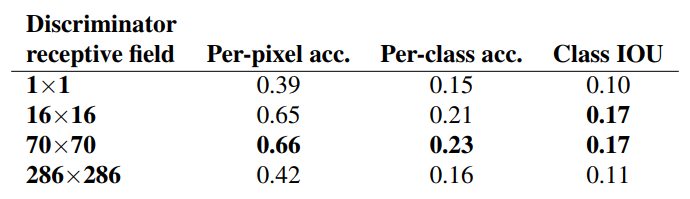

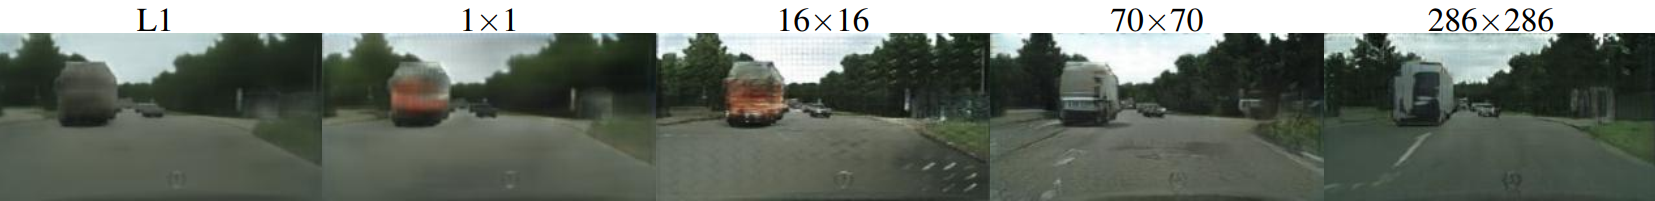

# Рецептивное поле (поле восприятия)



> <p line-height:0.3><font size='2'> В тексте будет встречаться понятие - свойства/признаки/характеристики, карта признаков или карта свойств, что эквивалентно английскому термину - feature / feature map (на жаргоне нейронщиков - фичи). Чтобы вы не запутались оба этих слова в данном контексте имеют одинаковую конатацию</font></p>



Рецептивное поле или поле восприятия — это, пожалуй, одна из самых важных концепций свёрточных нейронных сетей (CNN), которая заслуживает большего внимания в литературе. Все современные методы распознавания объектов создают архитектуру моделей на основе этой идеи. 

## Визуализация карты характеристик CNN фиксированного размера 

<b>Поле восприятия</b> определяется как область во входном пространстве, на которую смотрит часть сверточной карты признаков(т.е. на которую влияет). Свойства рецептивного поля описывает расположение его центра и размер. Однако не все пиксели в рецептивном поле одинаково важны для соответствующего признака CNN. В пределах воспринимающего поля, чем ближе пиксель к центру поля, тем больший вклад он вносит в расчет выходного признака. Это означает, что свойство не только смотрит на конкретную область (то есть ее воспринимающее поле) во входном изображении, но также экспоненциально фокусируется на его середине. Эта важная особенность будет объяснена ниже. На данный момент мы сосредоточимся на вычислении местоположения и размера конкретного рецептивного поля.

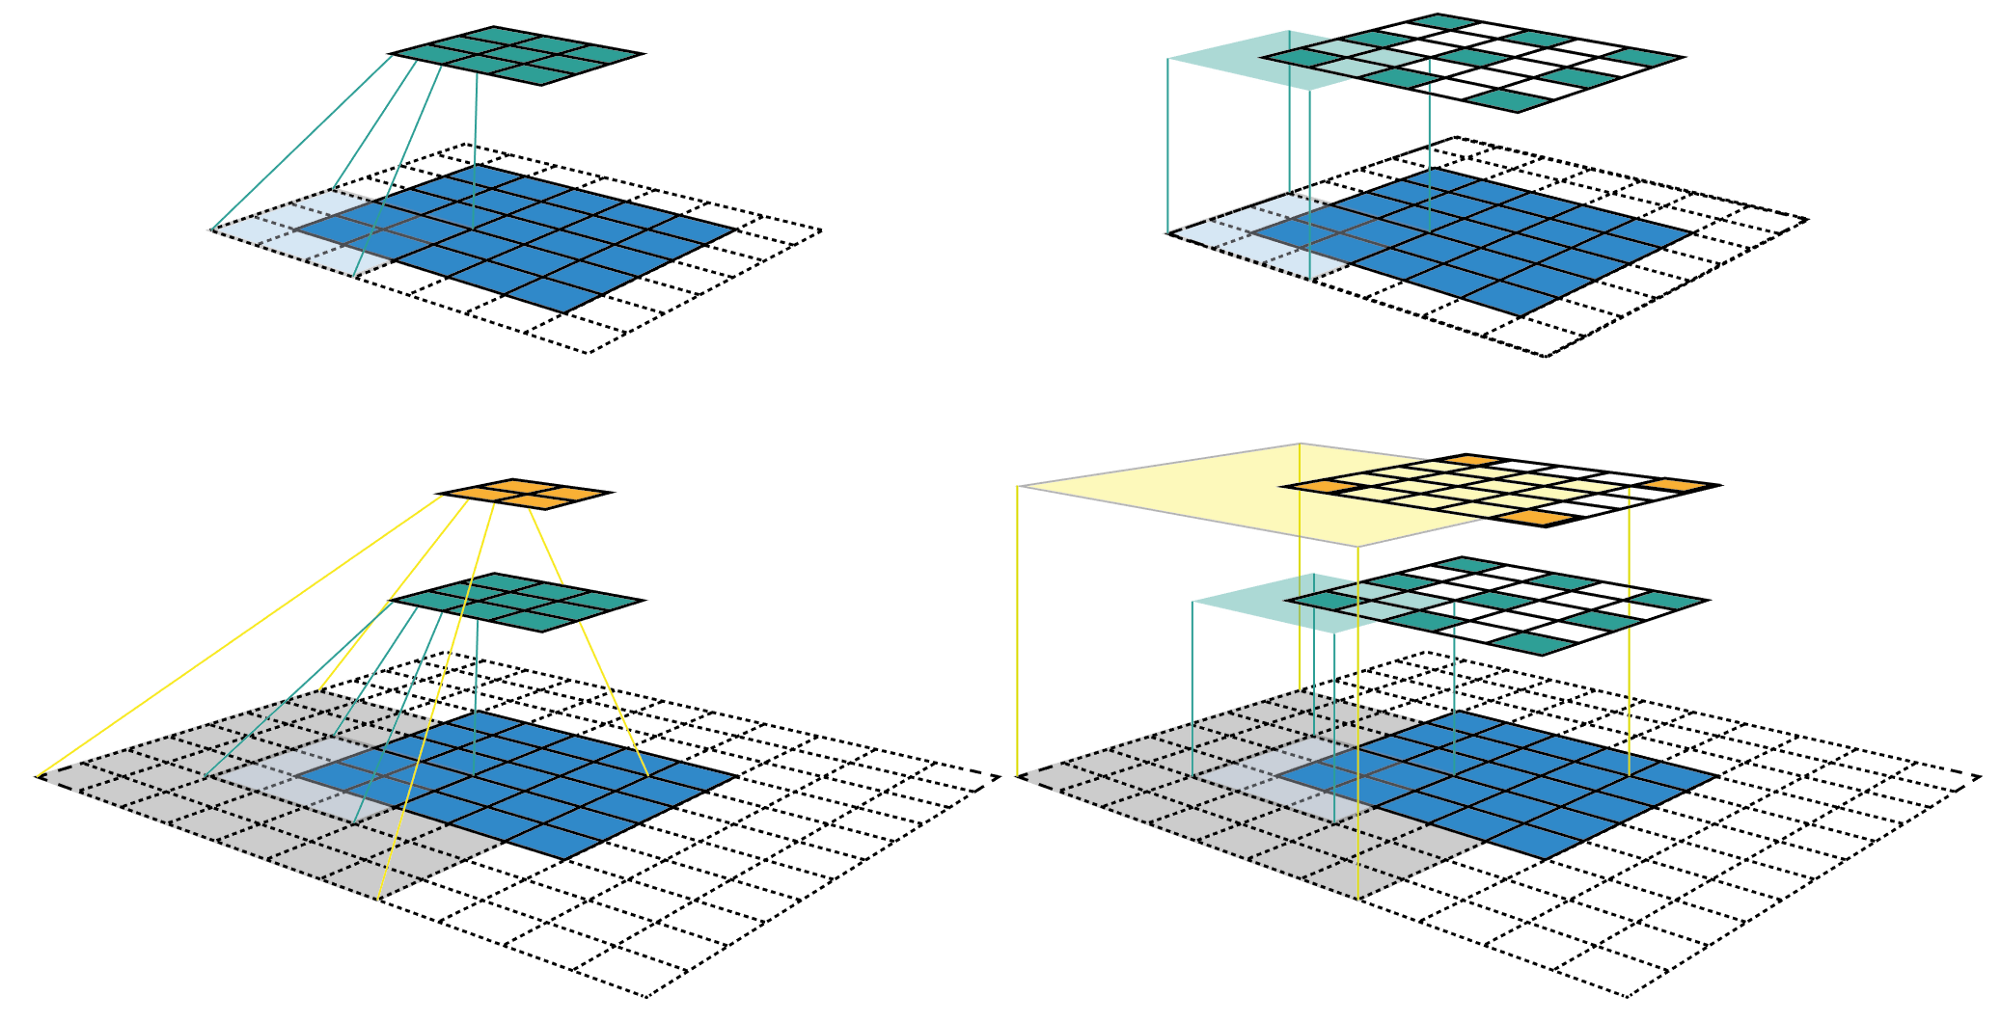

<b>Рисунок1.</b> Показывает пример рецептивного поля<br> Применяя светку с размером ядра k=3х3 (kernel size), размер заполнения (padding size) p=1x1 и шаг s=2x2 (stride)на входной карте 5х5 (синий квадрат) мы получаем карту характеристик 3х3 (зеленый квадратик), далее применяя туже свертку по карте 3х3 мы получаем карту характеристик 2х2 (оранжевый квадратик). Количество выходных характеристик на каждом шаге можно рассчитать, используя следующую формулу:<br>
$$n_{out}=[\frac{(n_{in}+2p-k)}s]+1$$,где n<sub>in</sub> – число входных характеристик, n<sub>out</sub> – число выходных характеристик, k – ядро свертки(kernel size), p – размер заполнения свертки (padding size), s – шаг свертки (stride size)



> Обратите внимание, что в этом разборе для упрощения я предполагаю, что архитектура CNN является симметричной, а входное изображение - квадратным. Таким образом, оба измерения имеют одинаковые значения для всех переменных. Если архитектура CNN или входное изображение асимметричны, вы можете рассчитать атрибуты карты характеристик отдельно для каждого слоя.



<p>В левом столбце рисунка 1 показан общий принцип получения карты характеристик CNN. Глядя на эту карту, мы можем посчитать сколько свойств она содержит, но невозможно понять к чему относится каждое свойство (где лежит его центр) и насколько велика его область (центр и размер рецептивного поля).</p><p>Правый столбец на рисунке 1 показывает визуализацию CNN фиксированного размера, которая решает проблему сохранения размера всех карт признаков равными входному размеру изображения (карты). Каждый признак (свойство) отмечается в центре своего рецептивного поля. Поскольку все свойства на карте свойств имеют одинаковый размер рецептивного поля, мы можем просто нарисовать ограничивающую квадратную рамку вокруг одного свойства, чтобы представить размер его поля восприятия. Нам не нужно полностью отображать эту ограничивающую рамку до входного слоя, поскольку карта свойств уже представлена в том же самом размере, что и входной слой.


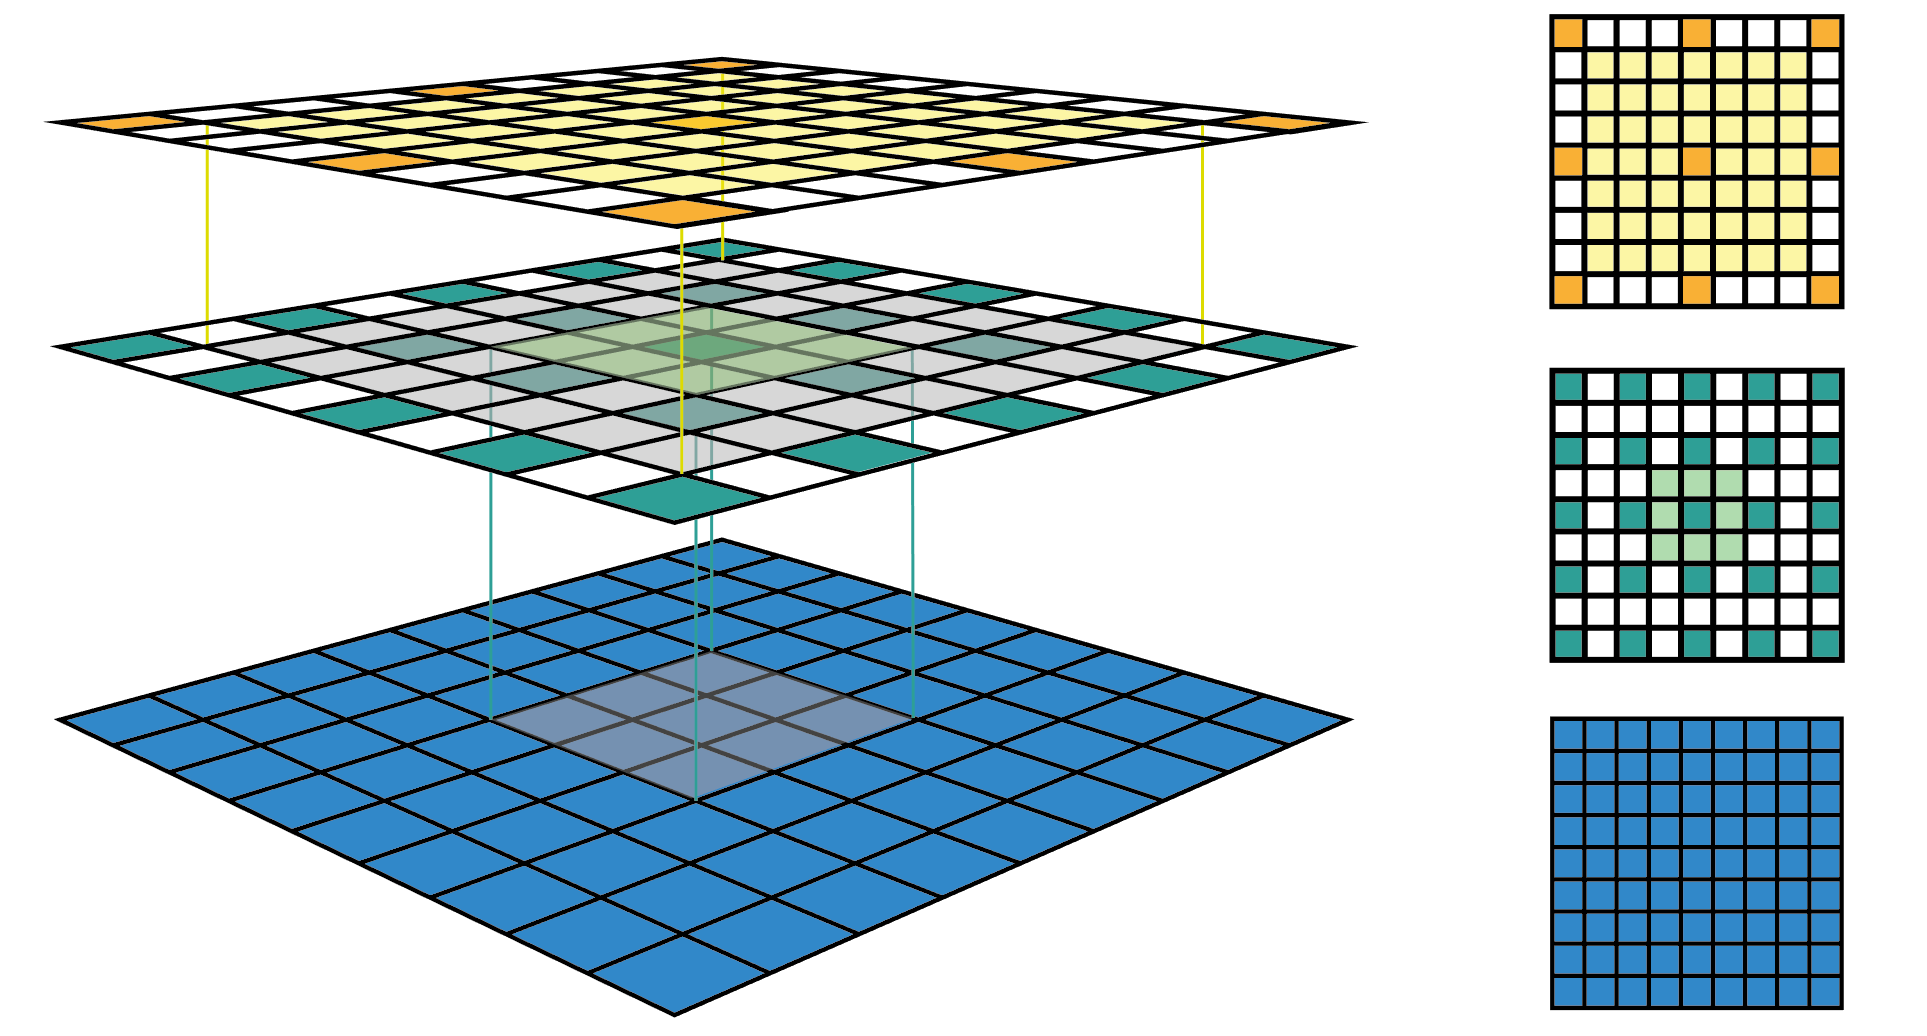

<b>Рисунок 2</b> иллюстрирует другой пример с использованием той же свертки, но примененной к большей входной карте - 9x9. Мы можем построить карты характеристик CNN фиксированного размера в 3D (слева) или в 2D (справа). Обратите внимание, что размер рецептивного поля на рисунке 2 очень быстро увеличивается до такой степени, что рецптивное поле центрального свойства второго слоя характеристик покрывает почти всю входную карту (7х7). Это важное открытие, которое было использовано для улучшения конструкций глубоких CNN.

## Расчет рецептивного поля
<p>Что бы рассчитать рецептивное поле на каждом слое, кроме числа свойств n на каждом из них нам необходимо отлеживать некоторую дополнительную информацию. К ней относится текущий размер рецептивного поля, расстояние(или прыжок) между двумя соседними свойствами и координата центра левого верхнего свойства (первого признака). Обратите внимание, что центральная координата признака определяется как центральная координата его рецептивного поля, как показано на приведенном выше рисунке. Применяя свёртку С с размером ядра k (kernel size), размер заполнения (padding size) p и шагом s (stride size) параметры выходного слоя можно рассчитать по следующим уравнениям:

(1)$$n_{out}=[\frac{(n_{in}+2p-k)}s]+1$$

(2)$$j_{out}=j_{in}*s   	$$

(3)$$r_{out}=r_{in}+(k-1)*j_{in}   	$$

(4)$$start_{out}=start_{in}+[\frac{k-1}{2}-p]*j_{in}   $$

<p><font size='3'>
<li><b>Уравнение 1</b> вычисляет число выходных признаков основываясь на числе входящих признаков (свойств) и свойств свертки.</li>
<li><b>Уравнение 2</b> считает прыжок или шаг на выходной карте свойств, который равен шагу во входной карте, умноженному на количество входных свойств, которые вы перешагиваете (перепрыгиваете) по мере выполнения свертки (stride size)</li>
<li><b>Уравнение 3</b> считает размер поля восприятия (рецептивного поля) выходной карты свойств, которое равно площади покрытой входными свойствами k<br> (k-1)*j<sub>in</sub>  плюс дополнительная область, покрытая рецептивным полем входных признаков, находящихся на границе.</li>
<li><b>Уравнение 4</b> вычисляет центральное положение рецептивного поля первого входного свойства, которое равно центральному положению первого входного свойства(элемента) плюс расстояние от местоположения первого входного свойства до центра первой свертки минус отступ. </li>
</p>


><font size='3'>Первый слой – это входной слой, который всегда имеет следующие характеристики:<li>Число свойств n = размеру изображения (каждый пиксель, его свойство)<li>Рецептивное поле r = 1 (один пиксель)<li>Прыжок (расстояние между двумя соседними свойствами) j = 1<li>Центр координат первого свойства Start = 0.5</li>


Обратите внимание, на рисунке 3 я использовал систему координат, в которой центр первого свойства входного слоя находится на 0.5. Применяя четыре приведенных выше уравнения рекурсивно, мы можем вычислить размер рецептивных полей для всех карт признаков в CNN. На рисунке 3 показан пример того, как работают эти уравнения.

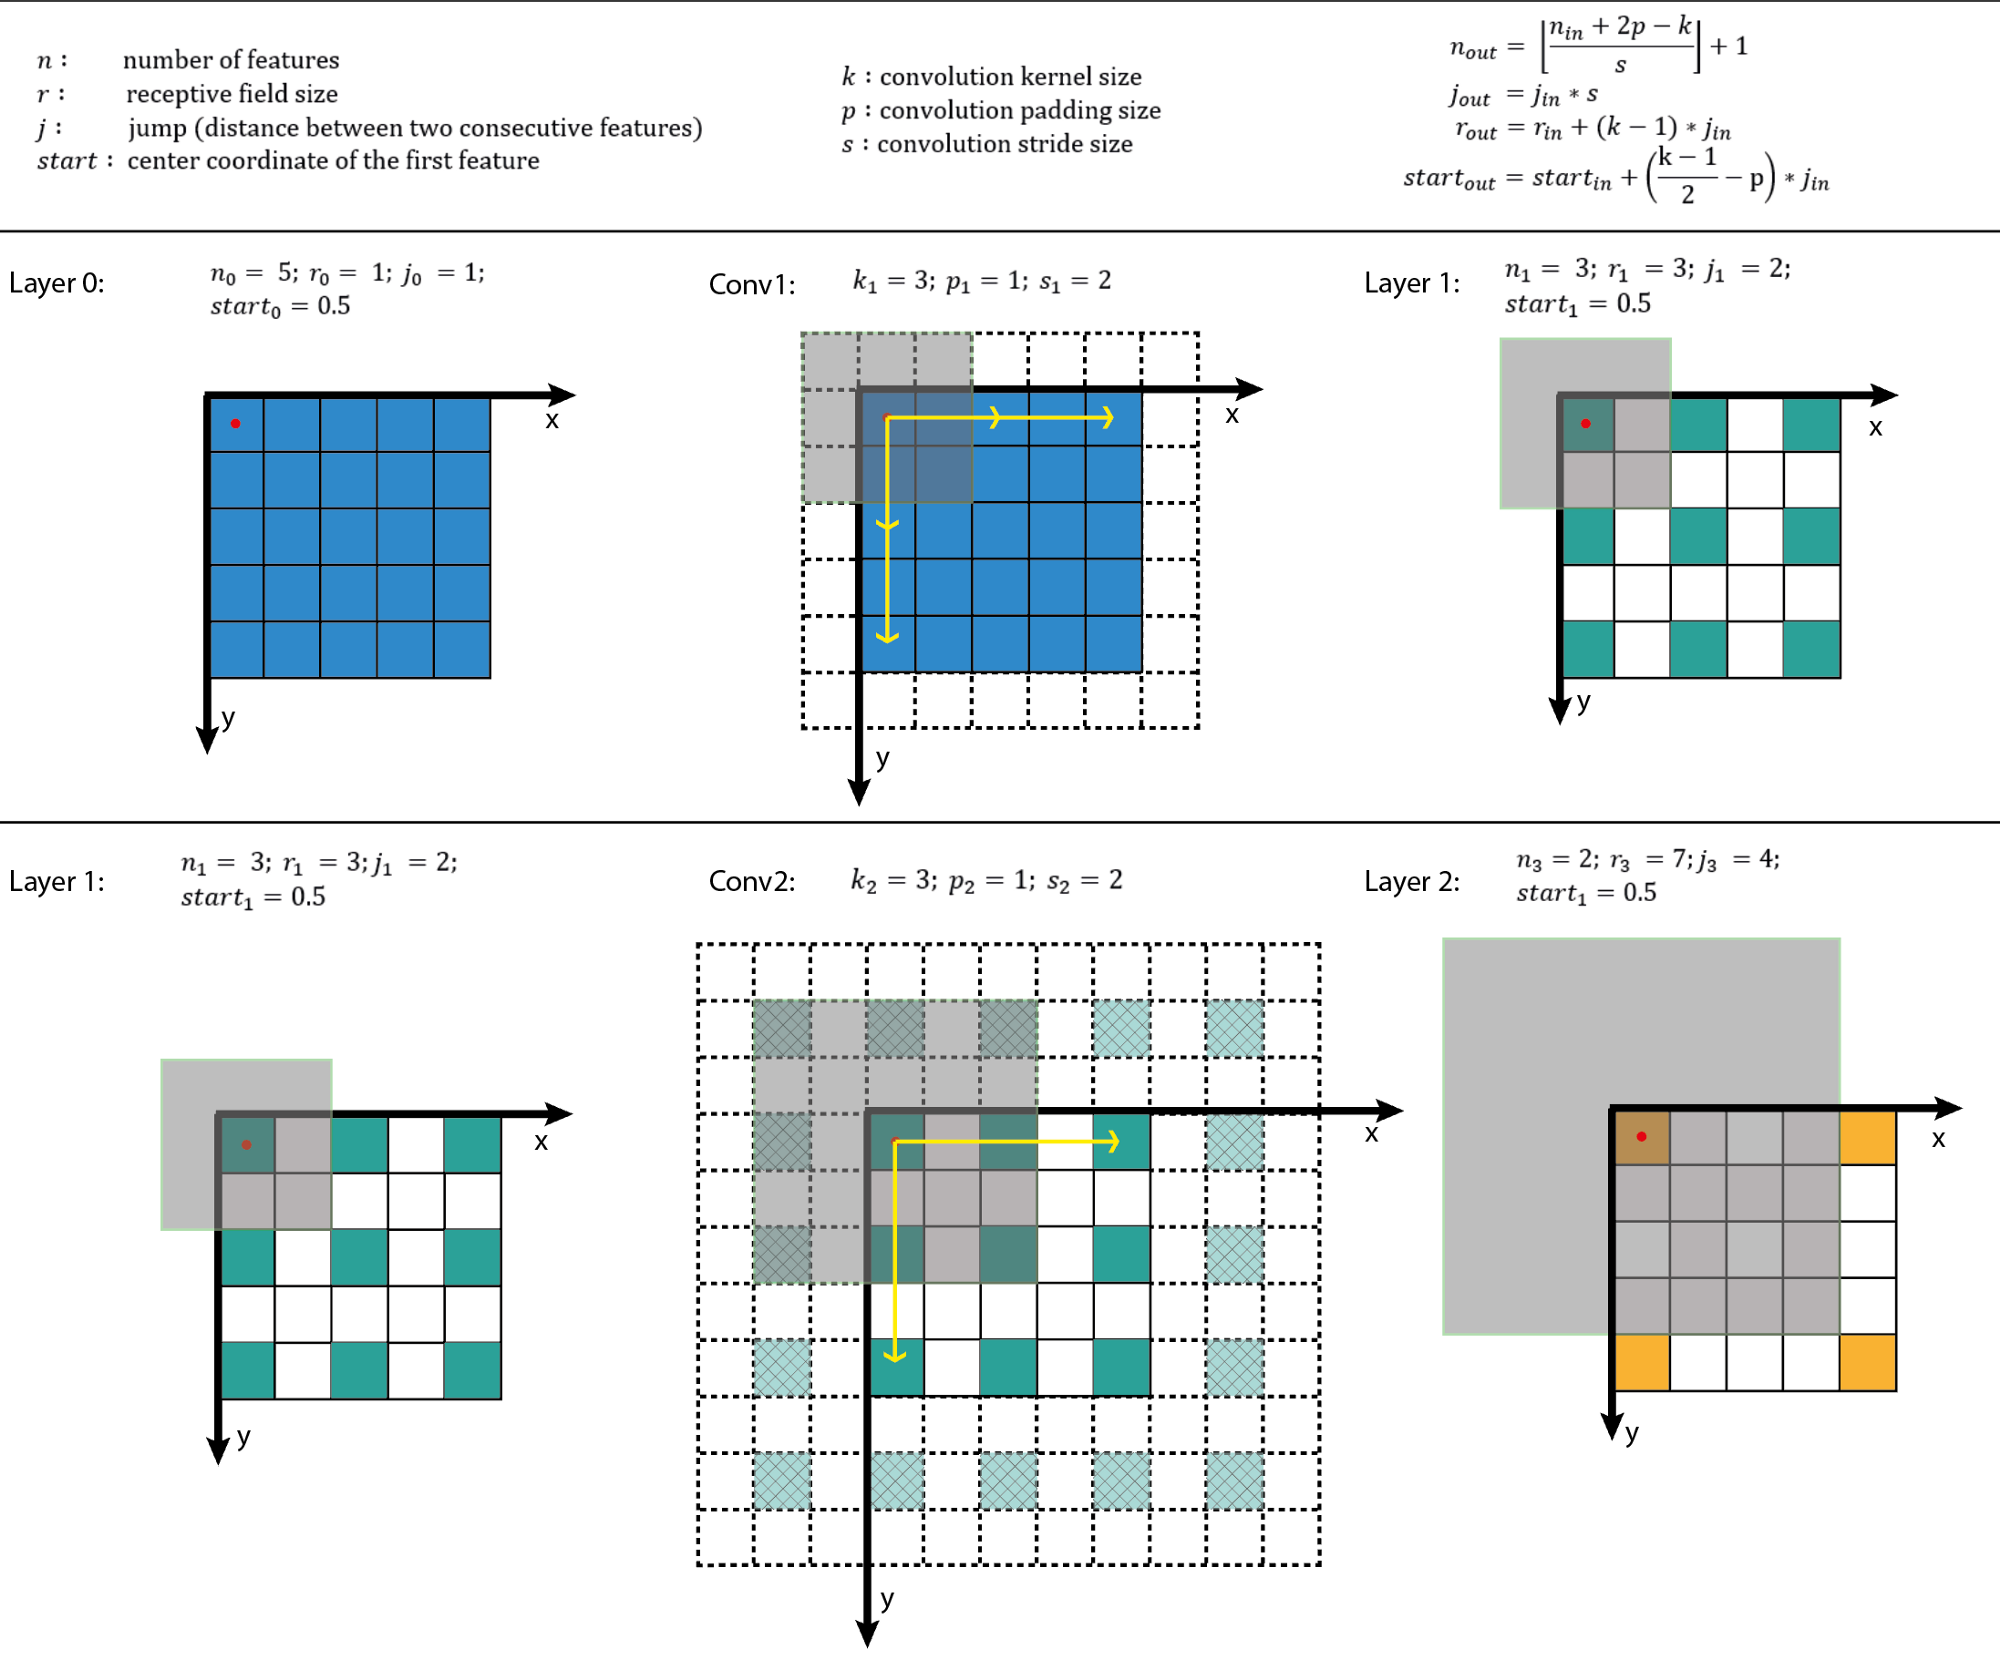

<b>Рисунок 3:</b> Применение расчета рецептивного поля, к примеру, приведенному на рисунке 1. 

В первой строке показаны обозначения и общие уравнения, а во второй и последней строке показан процесс их применения для расчета рецептивного поля выходного слоя с учетом информации о входном слое.

Ниже приведен код, который вычисляет информацию о рецептивном поле для всех слоев заданной архитектуры CNN. Он так же позволяет вводить имя любой карты признаков и индекс каждого признака в этой карте и возвращает размер и расположение центра соответствующего рецептивного поля.

In [ ]:
# Простой вариант расчёта  поля восприятия
 
# Ф-я рассчета размера эффективного поля восприятия
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

In [ ]:
"""
Рассчитываем в обратном порядке от выхода ко входу для рассматриваемого выше примера
"""
# Выходной слой
rf = receptive_field(1, 3, 2) # Выходной слой 1x1 пиксель с ядром свертки 3x3 (kernel_size) и шагом 2x2 (stride_size)
print('Поле восприятия: ', rf,'x',rf, sep='')

#Предпоследний слой
rf = receptive_field(rf, 3, 2)
print('Поле восприятия: ', rf,'x',rf, sep='')

Поле восприятия: 3x3
Поле восприятия: 7x7


In [ ]:
"""
Рассчитываем в обратном порядке от выхода ко входу  
"""
rf = receptive_field(1, 4, 1) # Выходной слой 1x1 пиксель с ядром свертки 4x4 (kernel_size) и шагом 1x1 (stride_size)
print('Поле восприятия: ', rf,'x',rf, sep='')
#Выходной слой С512 с ядром 4x4  и шагом 1x1 
rf = receptive_field(rf, 4, 1)
print('Поле восприятия: ', rf,'x',rf, sep='')
# PatchGAN слой С256 с 4x4 kernel и 2x2 stride
rf = receptive_field(rf, 4, 2)
print('Поле восприятия: ', rf,'x',rf, sep='')
# PatchGAN слой С128 с 4x4 kernel и 2x2 stride
rf = receptive_field(rf, 4, 2)
print('Поле восприятия: ', rf,'x',rf, sep='')
# Входной слой С64 с 4x4 kernel и 2x2 stride
rf = receptive_field(rf, 4, 2)
print('Поле восприятия: ', rf,'x',rf, sep='')

In [ ]:
"""
#Предположим, что изображение квадратное
Каждый сверточный слой требует следующих параметров:
    k_i: размер ядра свертки (kernel size)
    s_i: шаг (stride)
    p_i: заполнение (padding) (Если параметр padding = "SAME" ставим 2)

#Каждый i-й слой требует чтобы его параметры были полностью определены:
    n_i: Число свойств (параметров)слоя (для входного слоя n_1 = image_size)
    j_i: расстояние (в проекции на пиксельное расстояние) между центрами двух соседних центров свойств 
    r_i: рецептивное поле свойства в i-ом слое
    start_i: положение рецептивного слоя первого свойства в слое i (idx начинается с 0, отрицательное значение означает, что центр попадает в отступ(padding))
"""
import math
# Задаем конфигурацию нашей сети [kernel size, stride, padding]
Net_config =   [[4,2,1],[4,2,1],[4,2,1],[4,1,1],[4,1,1]]
# Присваиваем имена слоев
layer_names = ['conv_64','conv_128','conv_256','conv_512','conv_out']
imsize = 2048 # предполагается, что картинка квадратная

def outFromIn(conv, layerIn):
  n_in = layerIn[0]
  j_in = layerIn[1]
  r_in = layerIn[2]
  start_in = layerIn[3]
  k = conv[0] # размер ядра свертки kernel size
  s = conv[1] # шаг свертки stride
  p = conv[2] # отступ padding
  
  n_out = math.floor((n_in - k + 2*p)/s) + 1
  actualP = (n_out-1)*s - n_in + k 
  pR = math.ceil(actualP/2)
  pL = math.floor(actualP/2)
  
  j_out = j_in * s
  r_out = r_in + (k - 1)*j_in
  start_out = start_in + ((k-1)/2 - pL)*j_in
  return n_out, j_out, r_out, start_out
  
def printLayer(layer, layer_name):
  print(layer_name + ":")
  print("\t кол-во параметров: %s \n \t скачок: %s \n \t размер Р. поля: %sх%s \t начало: %s " % (layer[0], layer[1], layer[2], layer[2], layer[3]))
 
layerInfos = []
#Входной слой всегда имеет параметры: n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
print ("-------Сводка по сети------")
currentLayer = [imsize, 1, 1, 0.5]
printLayer(currentLayer, "Входное изображени")
for i in range(len(Net_config)):
  currentLayer = outFromIn(Net_config[i], currentLayer)
  layerInfos.append(currentLayer)
  printLayer(currentLayer, layer_names[i])
print ("------------------------")

-------Сводка по сети------
Входное изображени:
	 кол-во параметров: 2048 
 	 скачок: 1 
 	 размер Р. поля: 1х1 	 начало: 0.5 
conv_64:
	 кол-во параметров: 1024 
 	 скачок: 2 
 	 размер Р. поля: 4х4 	 начало: 1.0 
conv_128:
	 кол-во параметров: 512 
 	 скачок: 4 
 	 размер Р. поля: 10х10 	 начало: 2.0 
conv_256:
	 кол-во параметров: 256 
 	 скачок: 8 
 	 размер Р. поля: 22х22 	 начало: 4.0 
conv_512:
	 кол-во параметров: 255 
 	 скачок: 8 
 	 размер Р. поля: 46х46 	 начало: 8.0 
conv_out:
	 кол-во параметров: 254 
 	 скачок: 8 
 	 размер Р. поля: 70х70 	 начало: 12.0 
------------------------


#Дискриминатор (PatchGAN)

Как мы видим из рисунка 2, модель Дискриминатора на вход принимает два изображения, исходное и целевое. Эти изображения объединяются на уровне каналов, т.е. два 3-х канальных изображения, после объединения становятся 6-ю канальным входным изображением

Конфигурация PatchGAN в документе представлена короткой записью: С64-С128-С256-С512, где С - это блок Conv2D-BatchNorm-LeakyReLU, а числа указывают количество фильтров. На первом слое BatchNormalization не используется, ядро светки 4x4 и шаг 2х2, кроме последного слоя. Наклон LeakyReLU установлен 0.2, на выходном слое активация sigmoid.

Веса модели инициализируются случайным гауссовским распределением со средним 0.0 и std = 0.02. Размер входного изображения 256х256.

Обновления весов Дискриминатора снижено в 2 раза по сравнению с Генератором.  Размер батча = 1 (одно изображение) в качестве оптимизатора используется Adam с learning rate = 0.0002 и параметрами  β1 = 0.5, β2 = 0.999.<br>
Что же, попробуем теперь из этого описания реализовать модель Дискриминатора в коде:

In [ ]:
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор
from tensorflow.keras.initializers import RandomNormal #Импортируем слой инициализации весов с номральным распределением
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Input, LeakyReLU, Activation, Concatenate, BatchNormalization, Dropout # Импортируем стандартные слои keras
from tensorflow.keras.utils import plot_model # функция для отрисовки структуры модели
import numpy as np
import matplotlib.pyplot as plt
import time


In [ ]:
# Пример модели Дискриминатора PatchGAN 70х70

# Определяем размер картинки
img_shape = (256, 256, 3)
conv_init = RandomNormal(mean=0.0, stddev=0.02) # создаем ф-ю инициализации весов модели с определённым распределением
gamma_init = RandomNormal(1., 0.02) # Для batch normalization 

def CBL(layer, filters,
        in_layer = False,
        out_layer = False,
        kernel_size = (4,4),
        strides = (2,2),
        padding = 'same'):       
    if out_layer:
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=conv_init)(layer)
    else:
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=conv_init)(layer)
    if not in_layer:
        x = BatchNormalization(momentum=0.9, epsilon=1.01e-5, gamma_initializer = gamma_init)(x)
    x = LeakyReLU(alpha=0.2) (x)
    return x

# определяем модель Дискриминатора
def create_discriminator(img_shape):
  # Слой инициализации весов
  #Вход исходного изображения
  in_source_img = Input(shape=img_shape)
  # Вход целевого изображения
  in_target_img = Input(shape=img_shape)

  # Объединяем входные изображения по каналам
  merged = Concatenate()([in_source_img, in_target_img])
  d = CBL(merged, 64, in_layer = True)      # C64
  d = CBL(d, 128)                           # C128
  d = CBL(d, 256)                           # C256
  d = CBL(d, 512)                           # C512
  d = CBL(d, 512, out_layer = True)         # C512
  # Выходной слой
  out_dist = Conv2D(1, (4,4), padding='same', kernel_initializer=conv_init, activation='sigmoid')(d)
  # Создаем модель
  model = Model([in_source_img, in_target_img], out_dist)
  '''Компилируем модель с параметрами указанными разработчиками Pix2Pix''' 
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model


# Создаем модель
discrim = create_discriminator(img_shape)
# Выводим информацию о дискриминаторе
discrim.summary()  


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 6)  0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

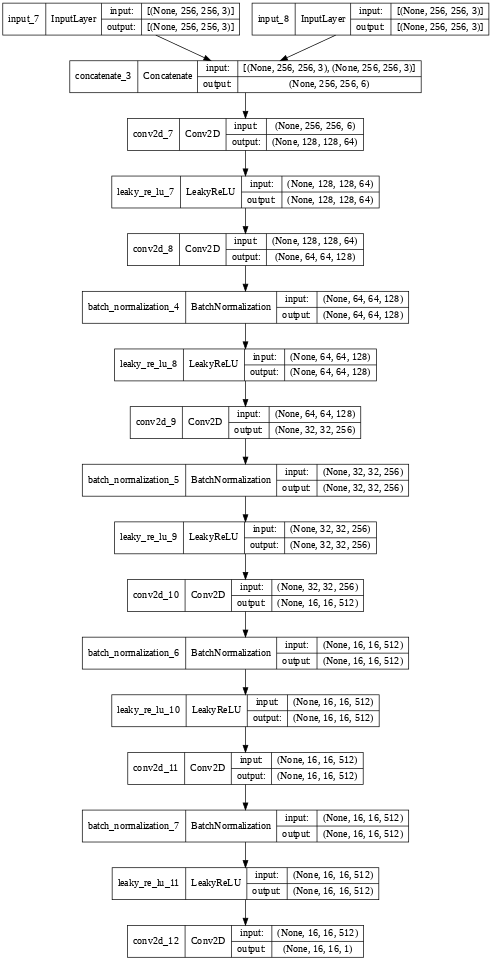

In [ ]:
# Выводим графичиское оторажение модели на экран
plot_model(discrim, to_file='discriminator_model_plot.png', dpi = 50, show_shapes=True, show_layer_names=True)

При выполнении кода сначала выводится информация о модели, что дает представление о том, как входное изображение трансформируется по слоям, и о количестве параметров модели.<br>
Мы видим, что два входных изображения объединяются вместе, чтобы создать один вход размером 256х256х6 для первого сверточного слоя. <br>
Объединение входных изображений можно было делать и до подачи в модель используя, к примеру библиотеку Numpy, но объединение изображений в моделе удобнее и нагляднее.<br>
Также можно увидеть, что на выходе модели мы имеем карту активации размером 16х16х1 пикселей (активаций) и одним каналом. Каждое значение на карте соответствует фрагменту (патчу) 70х70 пикселей входного изображения 256х256<br>
Дискриминатор представляет собой модель двоичной классификации, то есть он предсказывает выходные данные, как вероятность в диапазоне [0,1], в данном случае вероятность того, является ли входное изображение реальным или из целевого набора данных. Набор значений может быть усреднен, чтобы дать итоговый прогноз fake/real. При обучении цель сравнивается с матрицей целевых значений, 0 для фальшивых и 1 для реальных.

# Генератор (U-NET)

Модель генератора encoder-decoder использует архитектуру U-NET. На входе модель берет изображение из набора А (источник) и генерирует целевое изображение похожее, а в идеале неотличимое от изображений в наборе B (целевой набор).<p> Для этого сначала выполняется понижающая дискретизация или кодирование входного изображения до уровня узкого места (бутылочного горлышка), а затем повышающая дискретизация или декодирование представления узкого места до размера выходного изображения. Архитектура U-Net означает, что между слоями кодирования и соответствующими слоями декодирования добавляются прямые соединения, по которым передаются неискаженные последующими слоями данные. Эти соединения, как бы образуют U-образную форму, отсюда и название сети.</p><p> На рисунке ниже показана принципиальная схема сети U-NET в сравнении с обычным Encoder-decoder'м



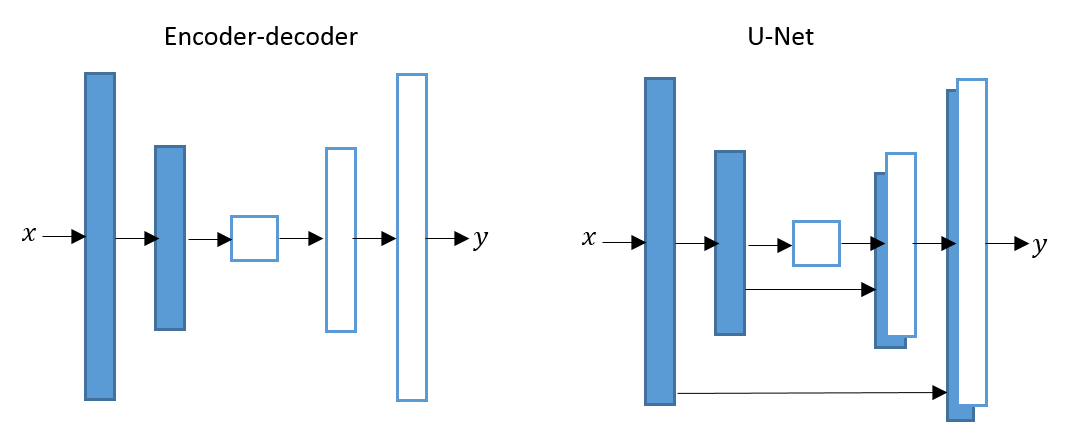

Энкодер и декодер состоят из стандартного набора блоков:
* Свертка c размером ядра 4х4
* Batch Normalization
* Dropout 50% применяется только в первых трех слоях декодера
* Activation ReLu в декодере и LeakyReLU - в энкодере

Такая стандартизация позволяет нам создать вспомогательные функции - слои, которые можно повторно вызывать, строя модель энкодера и декодера. Итак напишем наш U-NET Генератор:




## Код U-NET генератора

In [ ]:
# функция блока энкодера
def encoder_block(layer_in, n_filters, batchnorm=True): 
  """Аргументы:
              layer_in - вход слоя 
              n_filters - количество фильтров int
              batchnorm - логический 
  """
	# инициализируем веса слоя
  init = RandomNormal(mean=0.0, stddev=0.02)
	# Добавляем сверточный слой с понижением разрешения
  x = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# Добавляем BatchNormalization по условию
  if batchnorm:
    x = BatchNormalization()(x, training=True)
	# активация leaky relu
  x = LeakyReLU(alpha=0.2)(x)
  return x
 
# Функция блока декодера
def decoder_block(layer_in, bypass, n_filters, dropout=True):
  """Аргументы:
            layer_in - вход предыдущего слоя
            bypass - вход с выхода соответствующего слоя энкодера (того же размера)
            n_filters - количество фильтров int
            dropout - логический
  """
	# инициализируем веса слоя
  init = RandomNormal(mean=0.0, stddev=0.02)
	# Добавляем слой с повышением разрешения
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# Добавляем BatchNormalization
  g = BatchNormalization()(g, training=True)
	# Добавляем dropout по условию
  if dropout:
  	g = Dropout(0.5)(g, training=True)
	# обединяем со соответствующим слоем энкодера
  g = Concatenate()([g, bypass])
	# Активация relu
  g = Activation('relu')(g)
  return g
 
# Функция U-NET генератора
def create_unet_generator(image_shape=(256,256,3)):
	# инициализируем веса слоя
	init = RandomNormal(mean=0.0,stddev=0.02)
	# Задаем параметры входного слоя
	in_image = Input(shape=image_shape)
	# собираем каскад сверточных слоев энкодера C64-C128-C256-C512-C512-C512-C512-C512
	e1 = encoder_block(in_image, 64, batchnorm=False)
	e2 = encoder_block(e1, 128)
	e3 = encoder_block(e2, 256)
	e4 = encoder_block(e3, 512)
	e5 = encoder_block(e4, 512)
	e6 = encoder_block(e5, 512)
	e7 = encoder_block(e6, 512)
	# бутылочное горлышко, тут не применяем batchnormalization и меняем активацию на relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# собираем каскад деконв слоев декодера CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Выходной слой
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# собираем модель
	model = Model(in_image, out_image)
	return model

In [ ]:
unet_gen = create_unet_generator()
unet_gen.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  3136        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 128, 128, 64  0           ['conv2d_19[0][0]']              
                                )                                                           

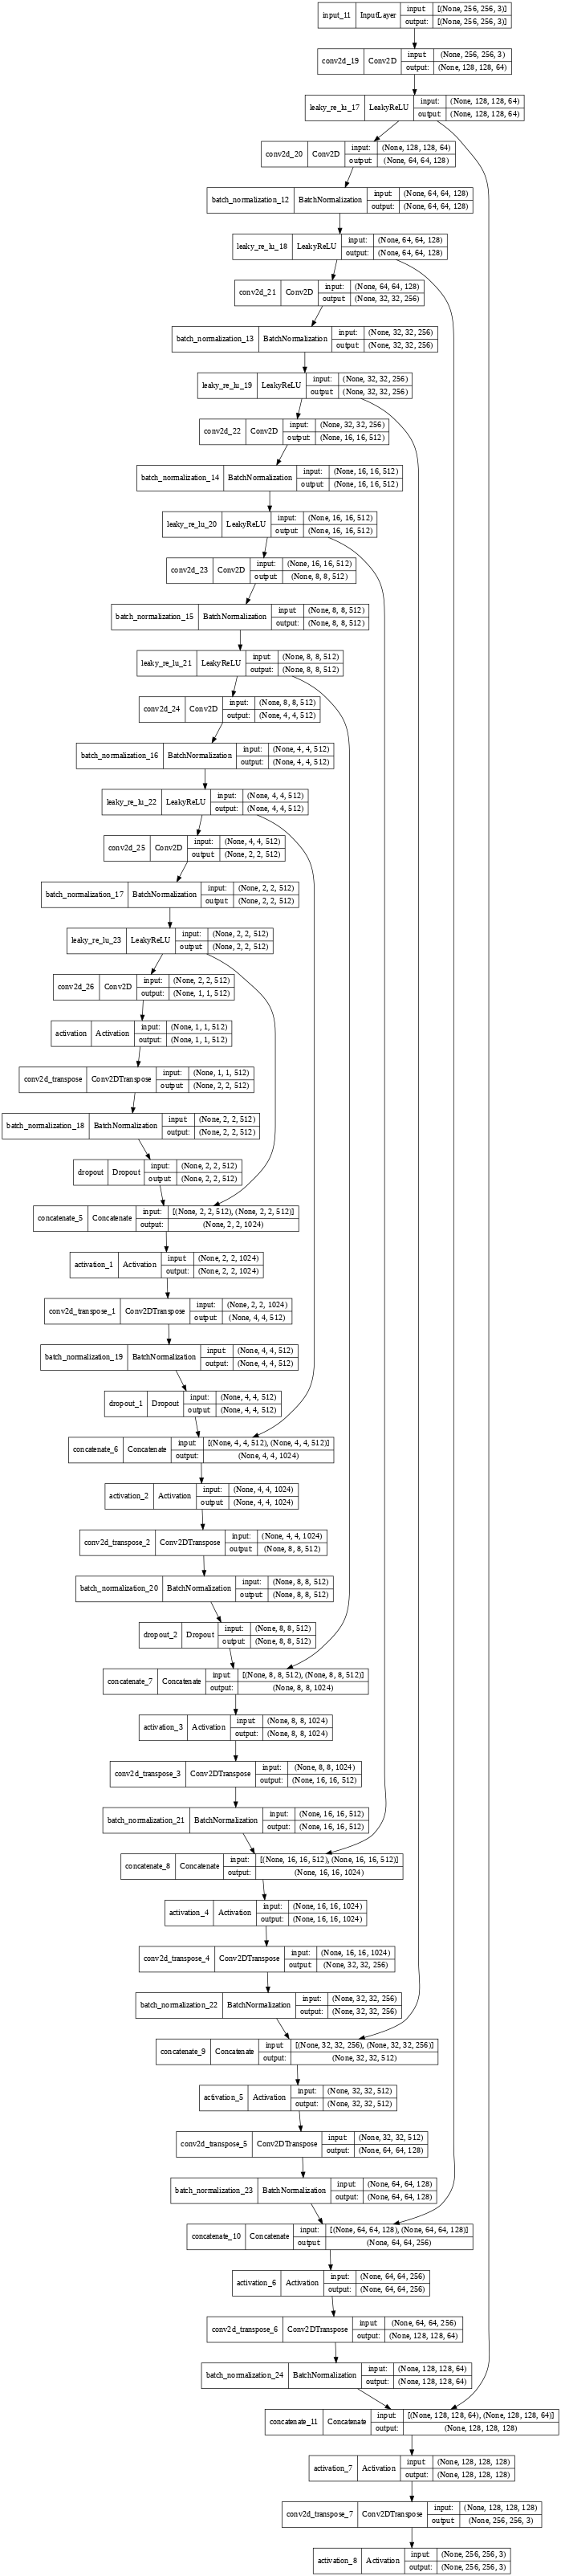

In [ ]:
# Выводим графичиское оторажение модели на экран
plot_model(unet_gen, to_file='unet_gen_model_plot.png', dpi=50, show_shapes=True, show_layer_names=True)

# Функции ошибок
<p>Модель Дискриминатора обучаетя непосредственно на реальных и сгенерированных изображениях, тогда как Генератор нет.
<p>Как и в других состязательных сетях Генератор в архитектуре Pix2Pix обучается с использованием Adversarial loss (состязательной ошибки) L2 или binary crossentropy, но также использует функцию ошибки L1 (MAE).</p><font size='3'>
<li>В первом случае Генератор обновляется стараясь минимизировать состязательную ошибку, чтобы обмануть Дискриминатор. Таким образом он учится создавать более реальные изображения.
<li>Во втором, Генератор старается минимизировать ошибку L1 (среднюю абсолютную ошибку) между сгенерированным и целевым изображением
<p>
Генератор обновляется за счет взешенной суммы ошибок, L2 и L1, где авторы метода рекомендуют взвешивать 100 к 1 в пользу потерь L1. Это сделано для того, что бы сильнее побуждать генератор синтезировать правдоподобную трансформацию входного изображения из набора А в набор В, а не просто правдоподобные изображения из целевого набора В.



Все выше сказанное достигается путем создания логической модели, использующей  веса существущих моделей Генератора и Дискриминатора. В этой логической или составной модели, Генератор устанавливается поверх Дискриминатора. Исходное изображение, из набора А, подается на вход Генератора и Дискриминатора. Выход Генератора также подключен ко входу Дискриминатора, после чего Дискриминатор предсказывает вероятность того, что Генератор трансформировал исходное изображение до целевого.

Дискриминатор обновляется автономно, поэтому веса повторно используются в составной модели, но помечены как не обучаемые. Составная модель обновляется двумя функциями ошибки, как было сказано выше. Одна из которых показывет насколько сгенерированные изображения похожи на реальные(целевые) (ошибка кросс-энтропии), и вторая (ошибка L1 или MAE) помогает выполненять реальную трансформацию изображения, которое сравнивается с выход модели генератора.

# Составная модель Pix2Pix

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_10 (Functional)          (None, 256, 256, 3)  54429315    ['input_23[0][0]']               
                                                                                                  
 model_9 (Functional)           (None, 16, 16, 1)    6968257     ['input_23[0][0]',               
                                                                  'model_10[0][0]']               
                                                                                           

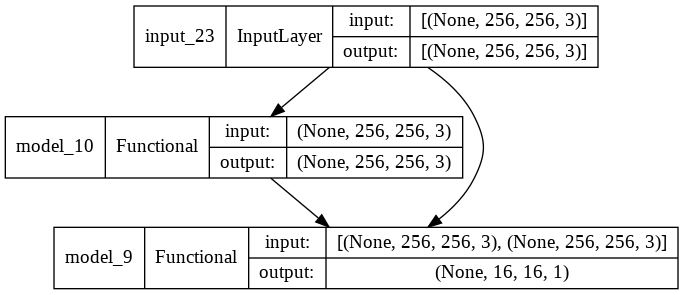

In [ ]:
# Комбинированная модель Pix2Pix define the combined generator and discriminator model, for updating the generator
def create_Pix2Pix(g_model, d_model, image_shape=(256,256,3)):
	# Замораживаем веса дискриминатора
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# Создаем вход для изображений набора А
	in_source = Input(shape=image_shape)
	# Подкючаем вход с набором изображений А ко входу генератора
	gen_out = g_model(in_source)
	# Подклюаем вход с набором изображений А и выход с генератора к входам дискриминатора
	dis_out = d_model([in_source, gen_out])
	# Собираем модель с одним входом изобр. набора А и двумя выходами: сгенерированое изображение и классифицирующий выход дискриминатора
	model = Model(in_source, [dis_out, gen_out])
	# Компилируем модель
	opt = Adam(learning_rate=0.0002, beta_1=0.5) # задаем параметры оптимизатора

  #Используем 2 ф-ции ошибки binary_crossentropy и L1 (MAE) 
  #Устанавливаем коэффициенты для ошибок 1 для binary_crossentropy  и 100 для МАЕ

	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model
 
# Задаем размер изображения
image_shape = (256,256,3)
# создаем модели
discr_model = create_discriminator(image_shape)
gen_model = create_unet_generator(image_shape)
# Создаем сборную модель Pix2Pix
Pix2Pix_gan_model = create_Pix2Pix(gen_model, discr_model, image_shape)
# Выводим информацию о сборной модели
Pix2Pix_gan_model.summary()
# plot the model
plot_model(Pix2Pix_gan_model, to_file='Pix2Pix_gan_model_plot.png', show_shapes=True, show_layer_names=True)

**Содержание**:

1. Теория
2. [Практический ноутбук](https://colab.research.google.com/drive/1Q78SIkgM8HyGXYtnYx_aOg574VQrMzWG?usp=sharing)